# Building a Pytorch-based end-to-end ML workflow on Vertex AI

**Learning Objectives:**
1. Learn how to create a train and a validation split with BigQuery
1. Learn how to wrap a Pytorch model into a Docker container and train in on Vertex AI
1. Learn how to use the hyperparameter tuning engine on Vertex AI to find the best hyperparameters
1. Learn how to deploy a trained Pytorch model on Vertex AI as a REST API and query it

In this lab you will develop a multi-class classification training application, package it as a docker image and run the application on Vertex AI.The [dataset](../../../datasets/covertype/README.md) used in the lab is based on **Covertype Data Set** from UCI Machine Learning Repository.

The training code uses `Pytorch` for data pre-processing and modeling. The code has been instrumented using the `hypertune` package so it can be used with **Vertex AI** hyperparameter tuning.


## Setup

For this lab, you'll first need to build a special kernel containing all the dependencies we will need:

In [ ]:
!cd ../../../.. && make pytorch_kfp_kernel

Then you'll need to select the kernel in the notebook. Click on the current kernel on the top right corner of the notebook:

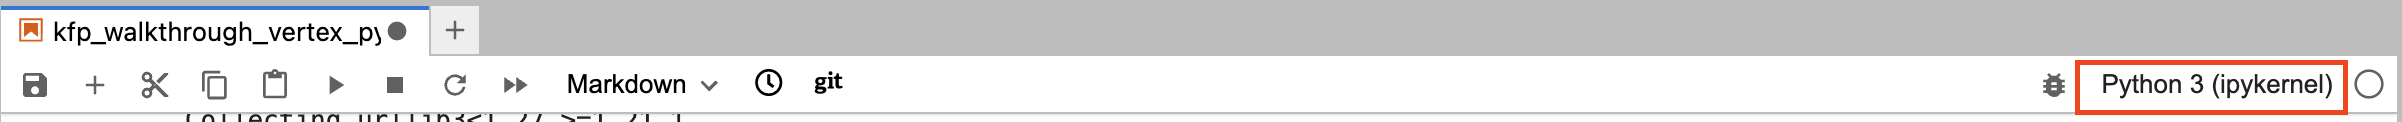

Then select `pytorch_kfp_kernel` in the pop-up selector:

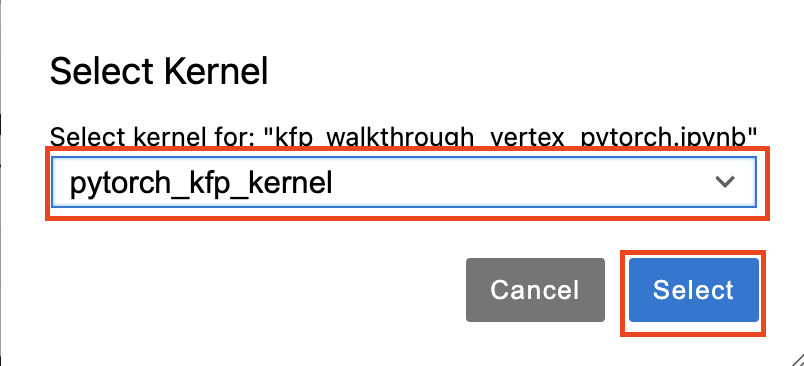

After that you should be able to run the following imports:

In [ ]:
import json
import os
import time
from collections import OrderedDict

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from google.cloud import aiplatform, bigquery
from google.cloud.aiplatform.prediction import LocalModel
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchtext.vocab import vocab

## Configure environment settings

Set location paths, connections strings, and other environment settings. Make sure to update   `REGION`, and `ARTIFACT_STORE`  with the settings reflecting your lab environment. 

- `REGION` - the compute region for Vertex AI Training and Prediction
- `ARTIFACT_STORE` - A GCS bucket in the created in the same region.

In [ ]:
REGION = "us-central1"

PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

ARTIFACT_STORE = f"gs://{PROJECT_ID}-kfp-artifact-store"

DATA_ROOT = f"{ARTIFACT_STORE}/data"
JOB_DIR_ROOT = f"{ARTIFACT_STORE}/jobs"
TRAINING_FILE_PATH = f"{DATA_ROOT}/training/dataset.csv"
VALIDATION_FILE_PATH = f"{DATA_ROOT}/validation/dataset.csv"
API_ENDPOINT = f"{REGION}-aiplatform.googleapis.com"

In [ ]:
os.environ["JOB_DIR_ROOT"] = JOB_DIR_ROOT
os.environ["TRAINING_FILE_PATH"] = TRAINING_FILE_PATH
os.environ["VALIDATION_FILE_PATH"] = VALIDATION_FILE_PATH
os.environ["PROJECT_ID"] = PROJECT_ID
os.environ["REGION"] = REGION

We now create the `ARTIFACT_STORE` bucket if it's not there. Note that this bucket should be created in the region specified in the variable `REGION` (if you have already a bucket with this name in a different region than `REGION`, you may want to change the `ARTIFACT_STORE` name so that you can recreate a bucket in `REGION` with the command in the cell below).

In [ ]:
!gsutil ls | grep ^{ARTIFACT_STORE}/$ || gsutil mb -l {REGION} {ARTIFACT_STORE}

## Importing the dataset into BigQuery

In [ ]:
%%bash

DATASET_LOCATION=US
DATASET_ID=covertype_dataset
TABLE_ID=covertype
DATA_SOURCE=gs://asl-public/data/covertype/dataset.csv
SCHEMA=Elevation:INTEGER,\
Aspect:INTEGER,\
Slope:INTEGER,\
Horizontal_Distance_To_Hydrology:INTEGER,\
Vertical_Distance_To_Hydrology:INTEGER,\
Horizontal_Distance_To_Roadways:INTEGER,\
Hillshade_9am:INTEGER,\
Hillshade_Noon:INTEGER,\
Hillshade_3pm:INTEGER,\
Horizontal_Distance_To_Fire_Points:INTEGER,\
Wilderness_Area:STRING,\
Soil_Type:STRING,\
Cover_Type:INTEGER

exists=$(bq ls -d | grep -w $DATASET_ID)
if [ -n "$exists" ]; then
   echo "$DATASET_ID already exists"
else
   echo "Creating $dataset"
   bq --location=$DATASET_LOCATION --project_id=$PROJECT_ID mk --dataset $DATASET_ID
fi

bq --project_id=$PROJECT_ID --dataset_id=$DATASET_ID load \
--source_format=CSV \
--skip_leading_rows=1 \
--replace \
$TABLE_ID \
$DATA_SOURCE \
$SCHEMA

## Explore the Covertype dataset 

In [ ]:
%%bigquery
SELECT *
FROM `covertype_dataset.covertype`

## Create training and validation splits

Use BigQuery to sample training and validation splits and save them to GCS storage
### Create a training split

In [ ]:
!bq query \
-n 0 \
--destination_table covertype_dataset.training \
--replace \
--use_legacy_sql=false \
'SELECT * \
FROM `covertype_dataset.covertype` AS cover \
WHERE \
MOD(ABS(FARM_FINGERPRINT(TO_JSON_STRING(cover))), 10) IN (1, 2, 3, 4)' 

In [ ]:
!bq extract \
--destination_format CSV \
covertype_dataset.training \
$TRAINING_FILE_PATH

### Create a validation split

In [ ]:
!bq query \
-n 0 \
--destination_table covertype_dataset.validation \
--replace \
--use_legacy_sql=false \
'SELECT * \
FROM `covertype_dataset.covertype` AS cover \
WHERE \
MOD(ABS(FARM_FINGERPRINT(TO_JSON_STRING(cover))), 10) IN (8)' 

In [ ]:
!bq extract \
--destination_format CSV \
covertype_dataset.validation \
$VALIDATION_FILE_PATH

In [ ]:
df_train = pd.read_csv(TRAINING_FILE_PATH)
df_validation = pd.read_csv(VALIDATION_FILE_PATH)

## Develop a training application
Now let's define the preprocessing and training application.

### Data Preprocessing
Our data includes both numerical and categorical features. Numerical features are values that can be measured or counted, such as height or weight. Categorical features have values that are discrete, such as gender or color.

To prepare our data for analysis, we need to standardize the numerical features and one-hot encode the categorical features. Standardizing numerical features means that we adjust their values so they have a mean of zero and a standard deviation of one. One-hot encoding categorical features means that we create a separate column for each category and assign a value of 1 or 0 to indicate which category the feature belongs to.

To do these preprocessing steps, we will put the numerical and categorical features in separate lists and apply the appropriate logic to each list.

In [ ]:
CATEGORICAL_FEATURES = ["Wilderness_Area", "Soil_Type"]
NUMERICAL_FEATURES = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
]
LABEL_COLUMN = "Cover_Type"

We now define the actual preprocessing logic.

We will normalize the numerical features and create a one-hot-encoded version of the categorical features. Both feature transformations have two steps: 
1. a fit step where we process the whole dataset and compute "states" or statistics needed by the transformations (e.g. mean and standard deviation for the numerical feature normalization and value-integer mapping for the categorical feature one-hot-encoding).
2. a transform step where the feature transformations are actually applied.

So, we define preprocessing `OneHotEncoder` and `StandardScaler` classes respectively that has methods of `fit(),` `transform()` and `serialize_constants`.

In [ ]:
class OneHotEncoder:
    def fit(self, series: pd.Series):
        categories = series.unique().tolist()
        dictionary = vocab(OrderedDict([(cat, 1) for cat in categories]))
        self.dictionary = dictionary
        return self

    def transform(self, feature: list, dictionary=None) -> torch.Tensor:
        if dictionary:
            assert type(dictionary) == list
            self.dictionary = vocab(
                OrderedDict([(cat, 1) for cat in dictionary])
            )

        indices = self.dictionary.lookup_indices(feature)
        indices = torch.tensor(indices, dtype=torch.long)
        one_hot = F.one_hot(
            indices, num_classes=len(self.dictionary.get_itos())
        )
        return torch.tensor(one_hot).float()

    def serialize_constants(self):
        return {"dictionary": self.dictionary.get_itos()}


class StandardScaler:
    def fit(self, series: pd.Series):
        self.mean = np.float64(series.mean())
        self.std = np.float64(series.std())
        return self

    def transform(self, feature: list, mean=None, std=None) -> torch.Tensor:
        if mean:
            self.mean = np.float64(mean)
        if std:
            self.std = np.float64(std)

        standardized = (feature - self.mean) / self.std
        return torch.tensor(standardized)[:, None].float()

    def serialize_constants(self):
        return {"mean": self.mean, "std": self.std}

This is a utility function to transform all the features by calling `transform` function, and concatenate all the columns.

In [ ]:
def preprocess(df, transformers):
    transformed_features = [
        transformers[c].transform(df[c].to_list())
        for c in df.columns
        if c != LABEL_COLUMN
    ]
    features = torch.cat(transformed_features, 1)

    label = df[LABEL_COLUMN].to_list()
    label = torch.LongTensor(label)
    return features, label

Now let's call the `fit()` function for all the columns separately and transform them with the `preprocess` function.

In [ ]:
# Preprocessing Categorical columns
transformers = {
    c_feature: OneHotEncoder().fit(df_train[c_feature])
    for c_feature in CATEGORICAL_FEATURES
}
transformers.update(
    {
        n_feature: StandardScaler().fit(df_train[n_feature])
        for n_feature in NUMERICAL_FEATURES
    }
)

training_transformed = preprocess(df_train, transformers)
validation_transformed = preprocess(df_validation, transformers)

### Export preprocessing states file for prediction
"Once the training and validation data have been transformed successfully. We can use `serialize_constants` to save the states to a JSON file.

In [ ]:
# export json for preprocessing
preprocessing_json = {
    c: transformers[c].serialize_constants()
    for c in df_train.columns
    if c != LABEL_COLUMN
}

with open("preprocessing.json", "w") as f:
    json.dump(preprocessing_json, f)

In [ ]:
preprocessing_json

### Define a model and training/validation step
We will define a simple neural network model with the training and validation steps in PyTorch.

In Pytorch, we can define a neural network model in a class that subclasses `torch.nn.Module`.<br>
There is an `__init__()` method that defines the layers and other components of a model, and a `forward()` method where the computation gets done. <br>
For more detail, refer to [the official document](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module).

Also, to make our model executable either on CPU or GPU device, we define [`torch.device`](https://pytorch.org/docs/stable/tensor_attributes.html#torch-device) depending on the cuda availability, specify in `torch.nn.Module.to()` method which take care of parameter dtype conversion.

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {device}")


# Model
class NeuralNetworkModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(54, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 7),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)


model = NeuralNetworkModel().to(device)

We use [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Let's define a training step that includes these operations:
- Call `Tensor.to()` to assign tensors to a specified device.
- Reset the gradients to zero (`optimizer.zero_grad()`).
- Execute model prediction. Instead of calling `Module.forward()` function defined above, we can simply call `Module()` since it takes care of running the `forward()` as well as other registered hooks.
- Compute the loss (`loss_fn(pred, y)`) and backpropagate it to the parameters (`loss.backward()`)
- Prepare for the next step by updating the optimizer (`optimizer.step()`)

In [ ]:
def train(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

In the similar way, we define the validation step.<br>
But note these additional operations:
- `model.eval()` to switch model to evaluation mode. This automatically switches behaviours of some operations (e.g. Dropout, Batch Normalization).
- `with torch.no_grad()` to disable gradient calculation. This helps reduce the memory consumption.
- compute and return accuracy along with validation loss.

In [ ]:
def validation(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss = 0
    correct = 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    validation_loss /= num_batches
    accuracy = correct / size
    return accuracy, validation_loss

### Run training locally.
Let's test if it runs locally before passing it to Vertex for training.

This will help identify and fix any errors in our code locally.

In [ ]:
# Dataset and DataLoader
BATCH_SIZE = 16

train_dataset = TensorDataset(*training_transformed)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
validation_dataset = TensorDataset(*validation_transformed)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}")
    train(train_dataloader, model, loss_fn, optimizer, device)
    accuracy, validation_loss = validation(
        validation_dataloader, model, loss_fn, device
    )
    print(
        ", ".join(
            (
                f"Validation Accuracy: {(100*accuracy):>0.1f}%",
                f"Avg loss: {validation_loss:>8f}",
            )
        )
    )
print("Done!")

## Hyperparameter tuning
### Prepare the hyperparameter tuning application.
Since the training run on this dataset is computationally expensive you can benefit from running a distributed hyperparameter tuning job on Vertex AI Training.

In [ ]:
TRAINING_APP_FOLDER = "training_app"
os.makedirs(TRAINING_APP_FOLDER, exist_ok=True)

### Write the tuning script. 
In order to run training in Vertex, we define a python file that includes all the code from preprocessing to training. <br>
Most of the code is the same as what we have in the cells above. But we will add a few additional lines of code to do hyperparameter training. These lines will save the trained mode and the preprocessing states for later use.

We will use of the `hypertune` library to report the `accuracy` as the metric for optimization.

In [ ]:
%%writefile {TRAINING_APP_FOLDER}/train.py
import os
import subprocess
import sys
import json

import fire
import hypertune
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchtext.vocab import vocab
from collections import OrderedDict
import torch.nn.functional as F


CATEGORICAL_FEATURES = ["Wilderness_Area", "Soil_Type"]
NUMERICAL_FEATURES = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']
LABEL_COLUMN = "Cover_Type"


class OneHotEncoder:
    def fit(self, series: pd.Series):
        categories = series.unique().tolist()
        dictionary = vocab(OrderedDict([(cat, 1) for cat in categories]))
        self.dictionary = dictionary
        return self

    def transform(self, feature:list, dictionary=None) -> torch.Tensor:
        if dictionary:
            assert type(dictionary) == list
            self.dictionary = vocab(
                OrderedDict([(cat, 1) for cat in dictionary])
            )

        indices = self.dictionary.lookup_indices(feature)
        indices = torch.tensor(indices, dtype=torch.long)
        one_hot = F.one_hot(
            indices, num_classes=len(self.dictionary.get_itos())
        )
        return torch.tensor(one_hot).float()

    def serialize_constants(self):
        return {"dictionary": self.dictionary.get_itos()}


class StandardScaler:
    def fit(self, series: pd.Series):
        self.mean = np.float64(series.mean())
        self.std = np.float64(series.std())
        return self

    def transform(self, feature:list, mean=None, std=None) -> torch.Tensor:
        if mean:
            self.mean = np.float64(mean)
        if std:
            self.std = np.float64(std)

        standardized = (feature - self.mean) / self.std
        return torch.tensor(standardized)[:, None].float()

    def serialize_constants(self):
        return {"mean": self.mean, "std": self.std}

def preprocess(df, transformers):
    transformed_features = [transformers[c].transform(df[c].to_list()) 
                            for c in df.columns if c != LABEL_COLUMN]
    features = torch.cat(transformed_features, 1)
    
    label = df[LABEL_COLUMN].to_list()
    label = torch.LongTensor(label)
    return features, label

    
def train_evaluate(job_dir, training_dataset_path, validation_dataset_path, batch_size, max_iter, hptune):
    
    df_train = pd.read_csv(training_dataset_path)
    df_validation = pd.read_csv(validation_dataset_path)

    if not hptune:
        df_train = pd.concat([df_train, df_validation])

    
    # Preproc Categorical columns
    transformers = {c_feature: OneHotEncoder().fit(df_train[c_feature]) 
                    for c_feature in CATEGORICAL_FEATURES}
    transformers.update({n_feature: StandardScaler().fit(df_train[n_feature]) 
                         for n_feature in NUMERICAL_FEATURES})

    training_transformed = preprocess(df_train, transformers)
    validation_transformed = preprocess(df_validation, transformers)

    # Dataset and DataLoader
    train_dataset = TensorDataset(*training_transformed)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    validation_dataset = TensorDataset(*validation_transformed)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model
    class NeuralNetworkModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(54, 32),
                nn.ReLU(),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16, 7)
            )

        def forward(self, x):
            return self.linear_relu_stack(x)

    model = NeuralNetworkModel().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    def train(dataloader, model, loss_fn, optimizer, device):
        model.train()
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            pred = model(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
    
    def validation(dataloader, model, loss_fn, device):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        validation_loss = 0
        correct = 0

        model.eval()
        with torch.no_grad():
            for X, y in dataloader:
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                validation_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        validation_loss /= num_batches
        correct /= size
        return correct, validation_loss

    epochs = max_iter
    for t in range(epochs):
        print(f"Epoch {t+1}")
        train(train_dataloader, model, loss_fn, optimizer, device)

    if hptune:
        accuracy, _ = validation(validation_dataloader, model, loss_fn, device)
        # Log it with hypertune
        hpt = hypertune.HyperTune()
        hpt.report_hyperparameter_tuning_metric(
          hyperparameter_metric_tag='accuracy',
          metric_value=accuracy
        )

    if not hptune:
        # Save the model
        model_filename = "model.pt"
        model_scripted = torch.jit.script(model)
        model_scripted.save(model_filename)
        gcs_model_path = "{}/{}".format(job_dir, model_filename)

        # export json for preprocessing
        preprocesinng_json = {c: transformers[c].serialize_constants() 
                              for c in df_train.columns if c != LABEL_COLUMN}
        preproc_json_filename = 'preprocessing.json'
        with open(preproc_json_filename, 'w') as f:
            json.dump(preprocesinng_json, f)
        gcs_preprocessing_json_path = "{}/{}".format(job_dir, preproc_json_filename)

        # send files to GCS
        subprocess.check_call(['gsutil', 'cp', model_filename, gcs_model_path], stderr=sys.stdout)
        subprocess.check_call(['gsutil', 'cp', preproc_json_filename, gcs_preprocessing_json_path], 
                              stderr=sys.stdout)


if __name__ == "__main__":
    fire.Fire(train_evaluate)

### Package the script into a docker image.
To run container-based cloud training, we define a Dockerfile.<br>
Notice that we are using the predefined pytorch image from Artifact Registry, and installing additional libraries including `cloud-hypertune` and `torchtext` to the training image. 

In [ ]:
%%writefile {TRAINING_APP_FOLDER}/Dockerfile

FROM us-docker.pkg.dev/vertex-ai/training/pytorch-xla.1-13.py310:latest
RUN pip install -U torchtext==0.14.1
WORKDIR /app
COPY train.py .

ENTRYPOINT ["python", "train.py"]

### Build the docker image. 

Make sure to update the URI for the base image so that it points to your project's **Container Registry**.<br>
You use **Cloud Build** to build the image and push it your project's **Container Registry**. As you use the remote cloud service to build the image, you don't need a local installation of Docker.

In [ ]:
ARTIFACT_REGISTRY_DIR = "asl-artifact-repo"
IMAGE_NAME = "pytorch_trainer_image"
IMAGE_TAG = "latest"
IMAGE_URI = f"us-docker.pkg.dev/{PROJECT_ID}/{ARTIFACT_REGISTRY_DIR}/{IMAGE_NAME}:{IMAGE_TAG}"

os.environ["IMAGE_URI"] = IMAGE_URI

In [ ]:
!gcloud builds submit --tag $IMAGE_URI $TRAINING_APP_FOLDER

### Submit an Vertex AI hyperparameter tuning job

Also, let's build a yaml file to define our hyperparameter tuning job specs. <br>
The training application has been designed to accept two hyperparameters that control our model:
- Max Iterations
- Batch Size

The file below configures Vertex AI hypertuning to run up to 5 trials in parallel and to choose from two discrete values of `max_iter` and the linear range between `16` and `128` for `batch_size`.

In [ ]:
TIMESTAMP = time.strftime("%Y%m%d_%H%M%S")
JOB_NAME = f"forestcover_tuning_{TIMESTAMP}"
JOB_DIR = f"{JOB_DIR_ROOT}/{JOB_NAME}"

os.environ["JOB_NAME"] = JOB_NAME
os.environ["JOB_DIR"] = JOB_DIR

In [ ]:
%%bash

MACHINE_TYPE="n1-standard-4"
REPLICA_COUNT=1
CONFIG_YAML=config.yaml

cat <<EOF > $CONFIG_YAML
studySpec:
  metrics:
  - metricId: accuracy
    goal: MAXIMIZE
  parameters:
  - parameterId: max_iter
    discreteValueSpec:
      values:
      - 10
      - 20
  - parameterId: batch_size
    integerValueSpec:
      minValue: 16
      maxValue: 128
    scaleType: UNIT_LINEAR_SCALE
  algorithm: ALGORITHM_UNSPECIFIED # results in Bayesian optimization
trialJobSpec:
  workerPoolSpecs:  
  - machineSpec:
      machineType: $MACHINE_TYPE
    replicaCount: $REPLICA_COUNT
    containerSpec:
      imageUri: $IMAGE_URI
      args:
      - --job_dir=$JOB_DIR
      - --training_dataset_path=$TRAINING_FILE_PATH
      - --validation_dataset_path=$VALIDATION_FILE_PATH
      - --hptune
EOF

gcloud ai hp-tuning-jobs create \
    --region=$REGION \
    --display-name=$JOB_NAME \
    --config=$CONFIG_YAML \
    --max-trial-count=5 \
    --parallel-trial-count=5

echo "JOB_NAME: $JOB_NAME"

Go to the Vertex AI Training dashboard and view the progression of the HP tuning job under "Hyperparameter Tuning Jobs".

### Retrieve HP-tuning results.

After the job completes you can review the results using GCP Console or programmatically using the following functions (note that this code supposes that the metrics that the hyperparameter tuning engine optimizes is maximized): 

In [ ]:
def get_trials(job_name):
    jobs = aiplatform.HyperparameterTuningJob.list()
    match = [job for job in jobs if job.display_name == JOB_NAME]
    tuning_job = match[0] if match else None
    return tuning_job.trials if tuning_job else None


def get_best_trial(trials):
    metrics = [trial.final_measurement.metrics[0].value for trial in trials]
    best_trial = trials[metrics.index(max(metrics))]
    return best_trial


def retrieve_best_trial_from_job_name(jobname):
    trials = get_trials(jobname)
    best_trial = get_best_trial(trials)
    return best_trial

You'll need to wait for the hyperparameter job to complete before being able to retrieve the best job by running the cell below.

In [ ]:
best_trial = retrieve_best_trial_from_job_name(JOB_NAME)

## Retrain the model with the best hyperparameters

You can now retrain the model using the best hyperparameters and using combined training and validation splits as a training dataset.

### Configure and run the training job

In [ ]:
batch_size = int(best_trial.parameters[0].value)
max_iter = int(best_trial.parameters[1].value)

In [ ]:
TIMESTAMP = time.strftime("%Y%m%d_%H%M%S")
JOB_NAME = f"JOB_VERTEX_{TIMESTAMP}"
JOB_DIR = f"{JOB_DIR_ROOT}/{JOB_NAME}"

MACHINE_TYPE="n1-standard-4"
REPLICA_COUNT=1

WORKER_POOL_SPEC = f"""\
machine-type={MACHINE_TYPE},\
replica-count={REPLICA_COUNT},\
container-image-uri={IMAGE_URI}\
"""

ARGS = f"""\
--job_dir={JOB_DIR},\
--training_dataset_path={TRAINING_FILE_PATH},\
--validation_dataset_path={VALIDATION_FILE_PATH},\
--batch_size={batch_size},\
--max_iter={max_iter},\
--nohptune\
"""

!gcloud ai custom-jobs create \
  --region={REGION} \
  --display-name={JOB_NAME} \
  --worker-pool-spec={WORKER_POOL_SPEC} \
  --args={ARGS}


print("The model will be exported at:", JOB_DIR)

### Examine the training output

The training script saved the trained model as the 'model.pkl' in the `JOB_DIR` folder on GCS.

**Note:** We need to wait for job triggered by the cell above to complete before running the cells below.

In [ ]:
!gsutil ls $JOB_DIR

## Deploy the model to Vertex AI Prediction
The model training is done. Now we will deploy the model using Vertex AI Predicion.

In [ ]:
PREDICT_APP_FOLDER = "predict_app"
os.makedirs(PREDICT_APP_FOLDER, exist_ok=True)
os.environ["PREDICT_APP_FOLDER"] = PREDICT_APP_FOLDER
os.environ["JOB_DIR"] = JOB_DIR

### Create TorchServe handler
We use Torchserve for the prediction handler. As we have custom preprocessing steps, we define a custom handler by subclassing `BaseHandler.` <br>

You can create a custom handler by having a class with any name, but it must have an `initialize()` and a `handle()` method.
- `initialize()`: this method is called when loading a model. We add a logic to load the state file in this function.
- `handle()`: the main function of this class. We define steps in this function.

And most cases, you will likely overwrite the `preprocess(),` `inference(),` and `postprocess()` functions to define custom preprocessing, inferencing, and postprocessing, respectively.<br>
We also copy the `transform()` function from our preprocessing classes and define them as `_one_hot_transformer` and `_standard_scale_transformer,` as this python file can't accommodate multiple classes.

For more detail, please refer to [the official TorchServe document](https://pytorch.org/serve/custom_service.html).

In [ ]:
%%writefile {PREDICT_APP_FOLDER}/handler.py
from ts.torch_handler.base_handler import BaseHandler

import logging
import os
import json
from collections import OrderedDict

logging.basicConfig(level=logging.INFO)

import numpy as np

import torch
from torchtext.vocab import vocab
import torch.nn.functional as F
    
CATEGORICAL_FEATURES = ["Wilderness_Area", "Soil_Type"]
NUMERICAL_FEATURES = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points']

    
class ModelHandler(BaseHandler):
    
    def __init__(self):
        self._context = None
        self.initialized = False
        self.explain = False
        self.target = 0


    def _one_hot_transformer(self, feature, dictionary):
        dictionary = vocab(OrderedDict([(cat, 1) for cat in dictionary]))
        
        indices = dictionary.lookup_indices(feature)
        indices = torch.tensor(indices, dtype=torch.long)
        one_hot = F.one_hot(indices, num_classes=len(dictionary.get_itos()))
        return torch.tensor(one_hot).float()

    def _standard_scale_transformer(self, feature, mean, std):
        standardized = (feature - np.float64(mean)) / np.float64(std)
        return torch.tensor(standardized)[:, None].float()    


    def initialize(self, context):
        self._context = context
        self.initialized = True
        
        #  load the model
        self.manifest = context.manifest

        properties = context.system_properties
        model_dir = properties.get("model_dir")

        self.device = "cpu"

        # Read model serialize/pt file
        serialized_file = self.manifest['model']['serializedFile']
        model_pt_path = os.path.join(model_dir, serialized_file)
        if not os.path.isfile(model_pt_path):
            raise RuntimeError("Missing the model.pth file")

        self.model = torch.jit.load(model_pt_path)
        
        # Read preprocesinng setting
        preprocessing_json_path = os.path.join(model_dir, "preprocessing.json")
        with open(preprocessing_json_path) as f:
            self.preprocessing_json = json.load(f)
        
        self.initialized = True


    def preprocess(self, _data):
        data = _data[0]
        
        preprocessed_data = [self._one_hot_transformer(data[c_feature], 
                                                       self.preprocessing_json[c_feature]["dictionary"]) 
                             for c_feature in CATEGORICAL_FEATURES]
        preprocessed_data.extend([self._standard_scale_transformer(data[n_feature],
                                                                   self.preprocessing_json[n_feature]["mean"],
                                                                   self.preprocessing_json[n_feature]["std"]) 
                                  for n_feature in NUMERICAL_FEATURES])
        preprocessed_data = torch.cat(preprocessed_data, 1)
        
        return preprocessed_data

    def inference(self, model_input):
        model_output = self.model.forward(model_input)
        return model_output

    def postprocess(self, inference_output):
        postprocess_output = torch.argmax(inference_output, dim=1)        
        return [postprocess_output.cpu().numpy().tolist()]

    def handle(self, data, context):
        model_input = self.preprocess(data)
        model_output = self.inference(model_input)
        output = self.postprocess(model_output)
        return output

### Package up files and buld a .mar file for prediction

Let's copy the trained model and the preprocessing state JSON file that were created during the cloud training.

In [ ]:
!gsutil cp $JOB_DIR/model.pt ./$PREDICT_APP_FOLDER
!gsutil cp $JOB_DIR/preprocessing.json ./$PREDICT_APP_FOLDER

We use `torch-model-archiver` command to create a prediction package specifying the model file and the preprocessing state JSON file.

For details, please refer to [the official README.md](https://github.com/pytorch/serve/blob/master/model-archiver/README.md#torch-model-archiver-for-torchserve)

In [70]:
%%bash 
source ../pytorch_kfp_kernel/bin/activate

torch-model-archiver -f \
  --model-name model \
  --version 1.0 \
  --serialized-file ./$PREDICT_APP_FOLDER/model.pt \
  --handler ./$PREDICT_APP_FOLDER/handler.py \
  --extra-files ./$PREDICT_APP_FOLDER/preprocessing.json \
  --export-path=./$PREDICT_APP_FOLDER

deactivate

### Deploy the model to Vertex AI Prediction
Now we deploy the model to Vertex AI Prediction.

In [ ]:
TIMESTAMP = time.strftime("%Y%m%d_%H%M%S")
DEPLOY_MODEL_GCS_URI = f"{ARTIFACT_STORE}/pytorch-model-deploy/{TIMESTAMP}"

!gsutil cp -r $PREDICT_APP_FOLDER $DEPLOY_MODEL_GCS_URI

In [ ]:
!gsutil ls -al $DEPLOY_MODEL_GCS_URI

### Uploading the trained model

In [ ]:
model_display_name = f"pytorch-model-{TIMESTAMP}"
model_description = (
    "PyTorch based forest cover classifier with the pre-built PyTorch image"
)
serving_container_image_uri = (
    "us-docker.pkg.dev/vertex-ai/prediction/pytorch-cpu.1-11:latest"
)

model = aiplatform.Model.upload(
    display_name=model_display_name,
    description=model_description,
    serving_container_image_uri=serving_container_image_uri,
    artifact_uri=DEPLOY_MODEL_GCS_URI,
)

model.wait()

print(model.display_name)
print(model.resource_name)

### Deploying the uploaded model

In [ ]:
machine_type = "n1-standard-4"

endpoint = model.deploy(
    machine_type=machine_type, accelerator_type=None, accelerator_count=None
)

### Serve predictions
#### Prepare the input file with JSON formated instances.

In [ ]:
instances = [
    {
        "Elevation": [2841.0],
        "Aspect": [45.0],
        "Slope": [0.0],
        "Horizontal_Distance_To_Hydrology": [644.0],
        "Vertical_Distance_To_Hydrology": [282.0],
        "Horizontal_Distance_To_Roadways": [1376.0],
        "Hillshade_9am": [218.0],
        "Hillshade_Noon": [237.0],
        "Hillshade_3pm": [156.0],
        "Horizontal_Distance_To_Fire_Points": [1003.0],
        "Wilderness_Area": ["Commanche"],
        "Soil_Type": ["C4758"],
    }
]

endpoint.predict(instances)

Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.